# Boosting Models
## Import Libraries

In [307]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mutual_info_score

In [308]:
from Utils import plot_corrlation_heatmap, plot_mi_heatmap
from FeatureSelectionUtils import compute_permutation_importance, plot_feature_importance

## Import Train and Test Datasets

In [309]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [310]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Version": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Version": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In [311]:
# helper function for calculating mutual information
def calculate_mutual_info(df, col1, col2):
    return mutual_info_score(df[col1], df[col2])

In this notebook, we will explore several promising Boosting methods, as listed below:
1. Gradient Boosting : Gradient Boosting builds a strong predictive model by combining an ensemble of weak learners, typically decision trees. It works by iteratively fitting new models to the residual errors of the previous models, with each subsequent model focusing on the areas where the previous ones performed poorly.
2. AdaBoost: AdaBoost is a boosting algorithm that combines multiple weak classifiers to build a strong classifier. It assigns weights to the training instances and focuses on the misclassified instances in subsequent iterations, adjusting the weights accordingly. Each weak classifier is trained sequentially, with more emphasis placed on the instances that are difficult to classify correctly.
3. XGBoost: XGBoost is an optimized implementation of gradient boosting, designed to be highly efficient, scalable, and accurate. It includes several enhancements over traditional gradient boosting, such as regularization techniques to prevent overfitting, parallelization of tree construction, and support for additional loss functions.
4. LightGBM: LightGBM is another gradient boosting framework that is designed for efficiency and speed. It uses a novel tree-based learning algorithm that splits the tree leaf-wise instead of level-wise, which reduces the number of nodes to be split and leads to faster training times. LightGBM also supports features like categorical feature optimization and parallel training.

For each model, we will first train it with all available features on the default setting, then apply feature selection method to select the optimal set of features, and perform hyperparameter tuning. The performance of the model in each stage will be observed and compared.

For Boosting models, there are 2 common ways for feature selection:
1. In-built Feature Importance Score: Boosting algorithms compute feature importance scores during the training process. Feature importance scores are typically based on metrics such as the total reduction in impurity (e.g., Gini impurity or entropy) achieved by splitting on a particular feature across all decision trees in the ensemble. These scores reflect the contribution of each feature to the overall performance of the model.
2. Permutation Importance: It assesses the importance of each feature by measuring how much the model's performance deteriorates when the values of that feature are randomly shuffled (permuted). The drop in performance after permutation reflects the importance of the feature: a larger drop indicates a more important feature, while a smaller drop suggests a less important feature. Permutation importance provides a more robust assessment of feature importance compared to feature importance scores, as it directly measures the impact of each feature on the model's performance.

Compared to Recursive Feature Elimination, in-built feature selection methods like feature importance scores and permutation importance are generally preferred in the context of boosting algorithms, as they offer a more comprehensive and efficient approach to feature selection based on the model's behavior and performance.

## Gradient Boosting

In [312]:
from sklearn.ensemble import GradientBoostingClassifier

In [313]:
# Set up a dataframe to store the results from different versions
train_metrics = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

### Build the Baseline Model before Feature Engineering

In [314]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

In [315]:
X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [316]:
gb_basic = GradientBoostingClassifier(random_state=47).fit(X_train_basic, Y_train.values.ravel())

In [317]:
# Predict the output based on our training and testing dataset
Y_train_pred_basic = gb_basic.predict(X_train_basic)
Y_test_pred_basic = gb_basic.predict(X_test_basic)

In [318]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Baseline before Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8393978030600235
Precision 	: 0.8492984758251741
Recall 		: 0.8252255786582974
F1 Score 	: 0.8370889916927823

**Test Set Metrics**
Accuracy 	: 0.8337818003913894
Precision 	: 0.6415425065731815
Recall 		: 0.4351961950059453
F1 Score 	: 0.5185972369819342


### Build the Baseline Model after Feature Engineering

In [319]:
gb = GradientBoostingClassifier(random_state=47).fit(X_train, Y_train.values.ravel())

In [320]:
# Predict the output based on our training and testing dataset
Y_train_pred = gb.predict(X_train)
Y_test_pred = gb.predict(X_test)

In [321]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "Baseline after Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8478815221655551
Precision 	: 0.8548419367747099
Recall 		: 0.8380737544134955
F1 Score 	: 0.8463748019017432

**Test Set Metrics**
Accuracy 	: 0.8257093933463796
Precision 	: 0.5900490539593553
Recall 		: 0.5005945303210464
F1 Score 	: 0.5416532647153426


### Eliminate the Features with permutation_importance=0

In [322]:
feature_importances, feature_names = compute_permutation_importance(gb, X_train, Y_train)

In [323]:
# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

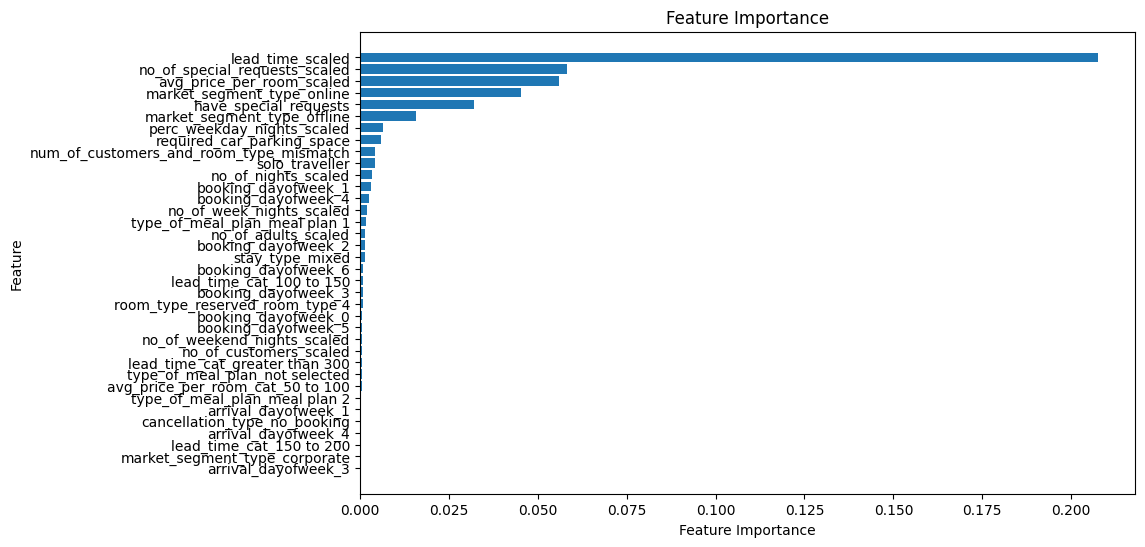

In [324]:
# Visualize permutation_importance
plot_feature_importance(feature_importances, feature_names)

In [325]:
selected_columns = feature_names

### Fit the Model again with the selected set of features

In [326]:
gb_selected = GradientBoostingClassifier(random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

In [327]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected = gb_selected.predict(X_train[selected_columns])
Y_test_pred_selected = gb_selected.predict(X_test[selected_columns])

In [328]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8471949784229109
Precision 	: 0.853505092869982
Recall 		: 0.8382699097685367
F1 Score 	: 0.845818901533894

**Test Set Metrics**
Accuracy 	: 0.8261986301369864
Precision 	: 0.5914505956552207
Recall 		: 0.5017835909631391
F1 Score 	: 0.5429398520424574


### Eliminate Features with low in-built feature importance

In [329]:
# Get feature importance score
feature_importances = gb_selected.feature_importances_
# Get feature names
feature_names = selected_columns

# Remove features with feature_importances<=0.001
feature_names = feature_names[feature_importances>0.001]
feature_importances = feature_importances[feature_importances>0.001]

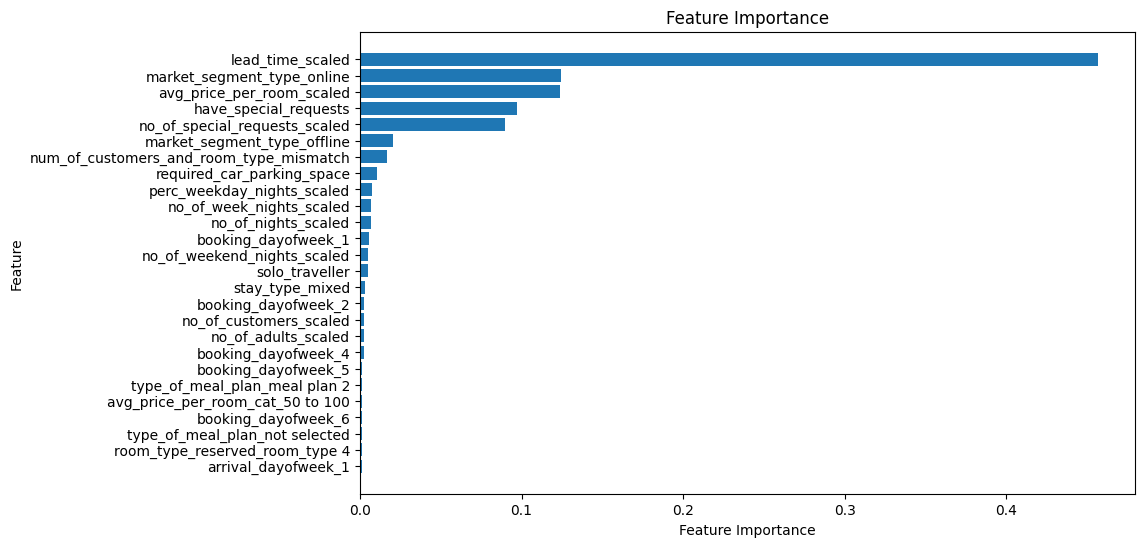

In [330]:
# Get indices that would sort feature importances
sorted_indices = np.argsort(feature_importances)
# Visualize permutation_importance
plot_feature_importance(feature_importances[sorted_indices], feature_names[sorted_indices])


Besides, there are some highly correlated columns, and we will remove one of them that contributes less to the model.

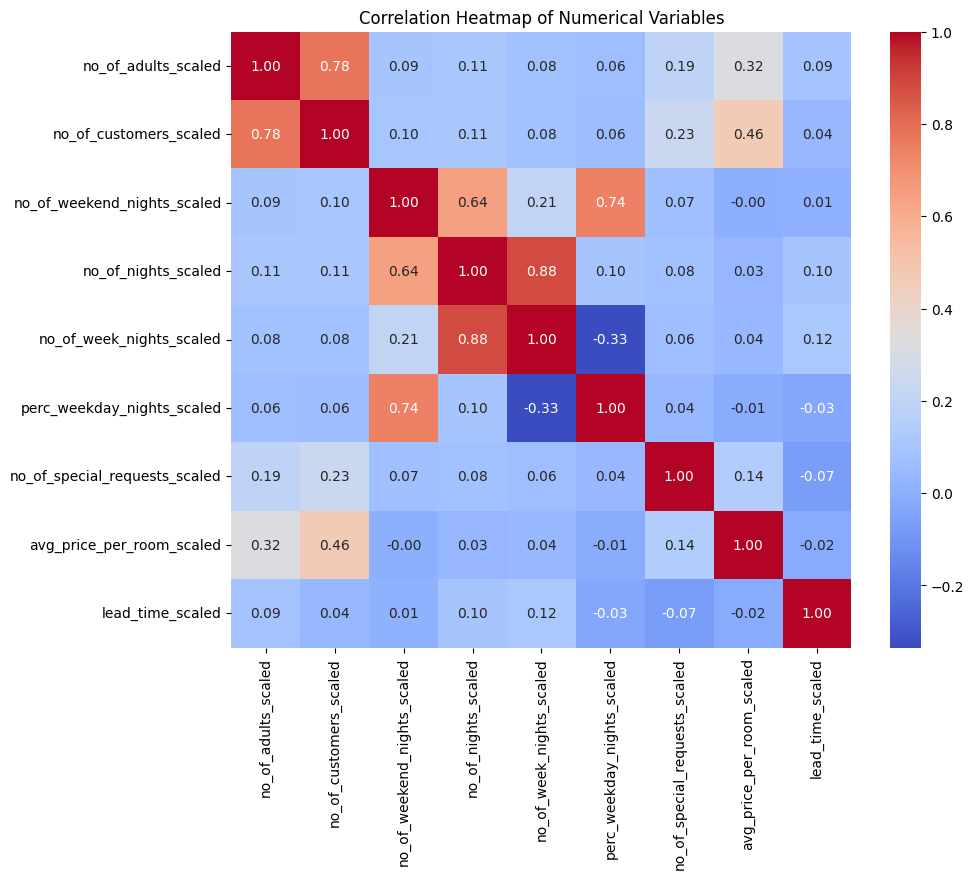

In [331]:
num_cols = [x for x in feature_names[sorted_indices] if '_scaled' in x]
plot_corrlation_heatmap(X_train[num_cols])

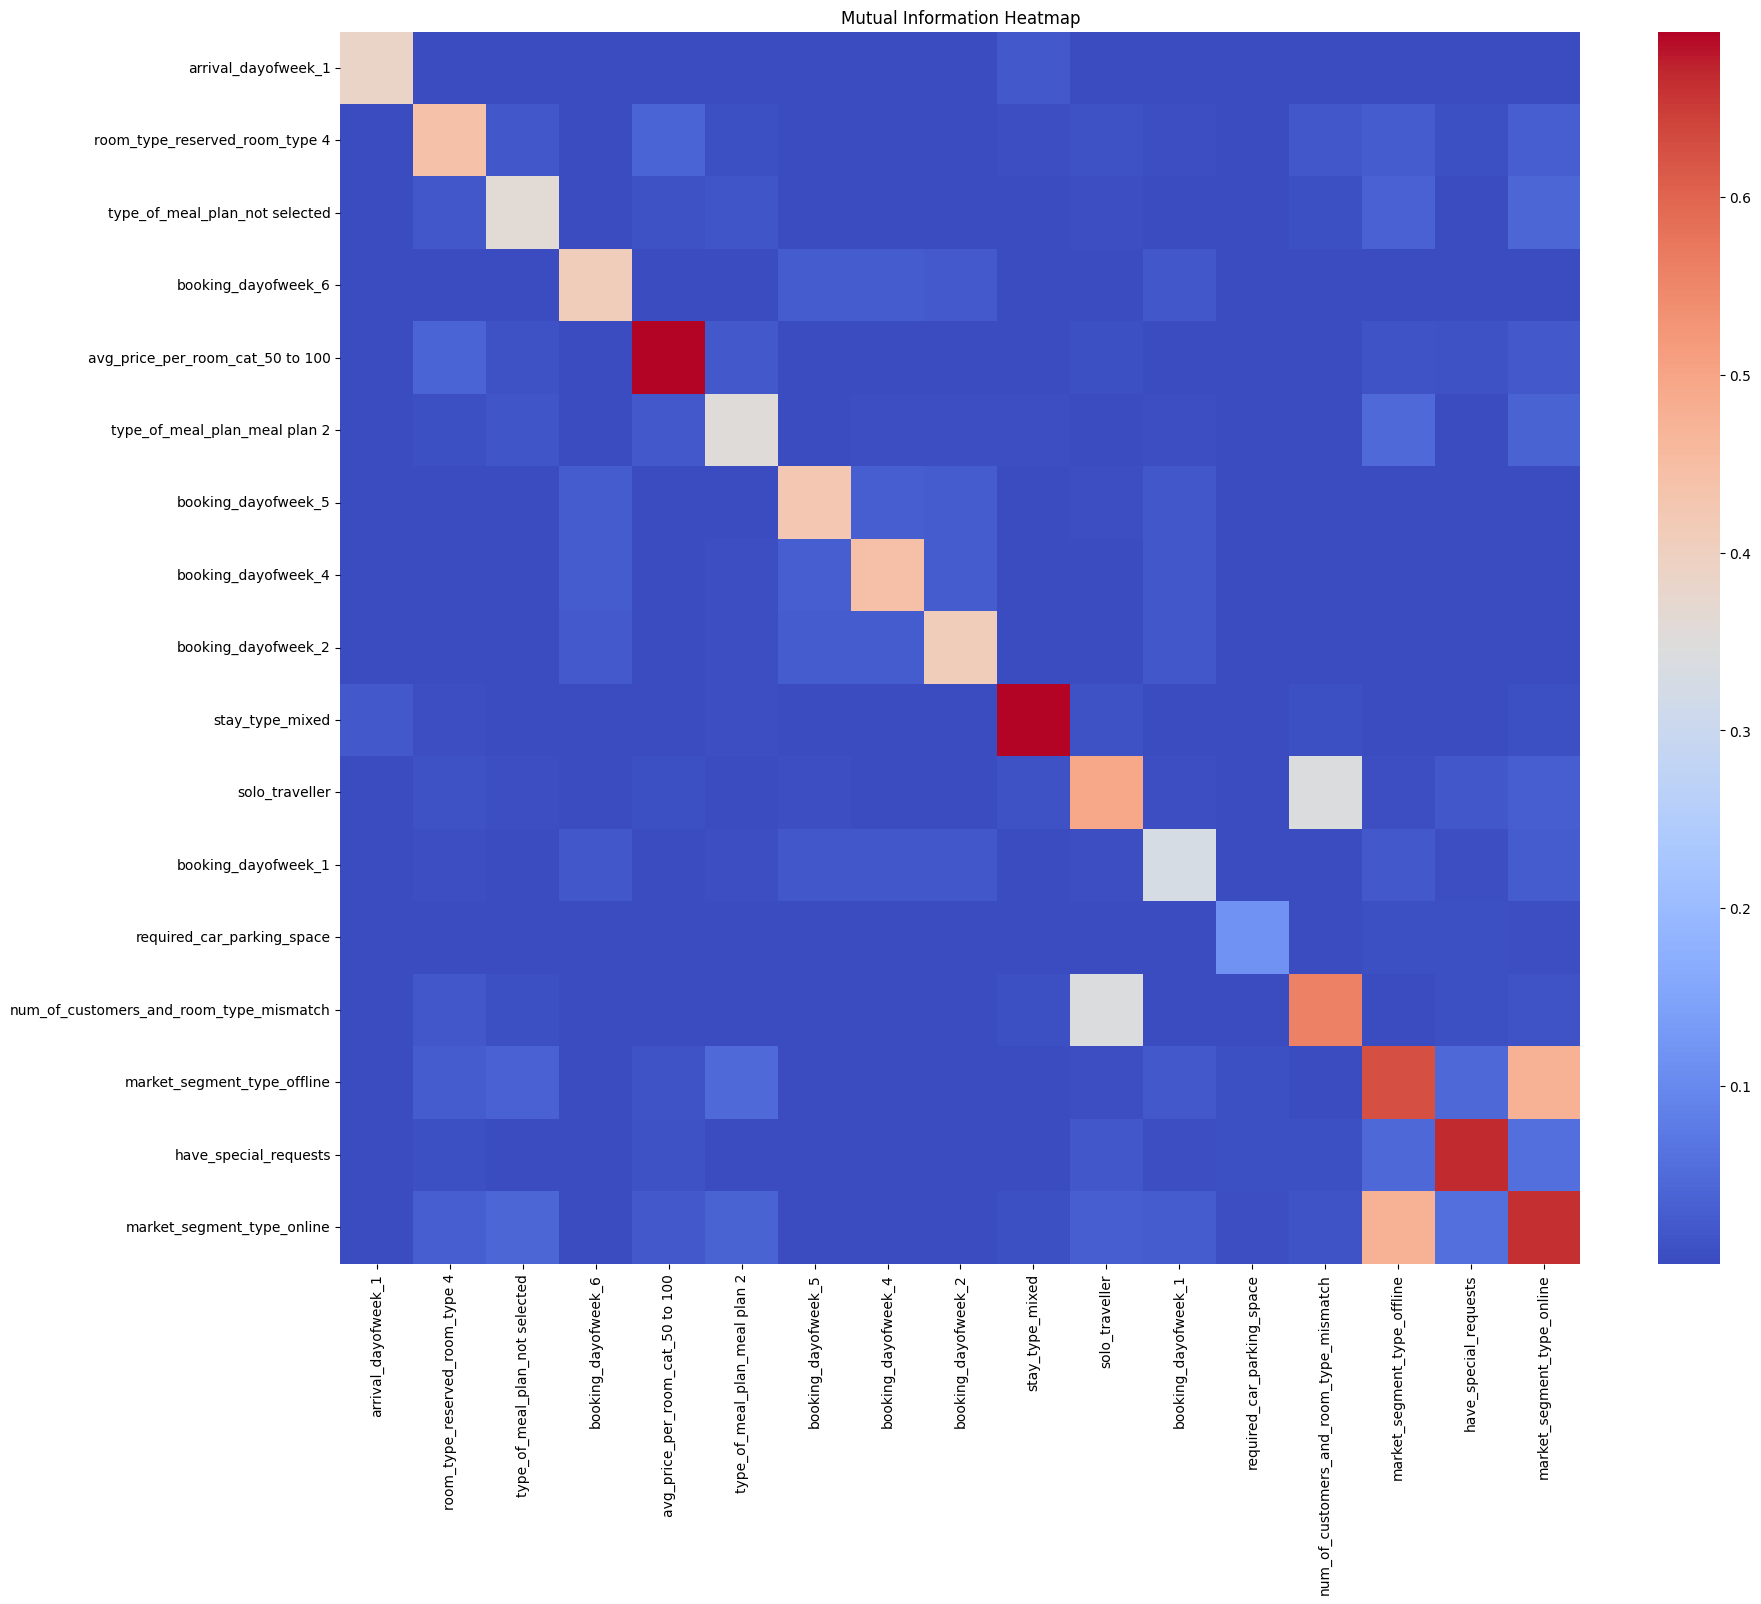

In [332]:
cat_cols = [x for x in feature_names[sorted_indices] if x not in num_cols]
plot_mi_heatmap(X_train[cat_cols])

Based on the observations, 'no_of_nights_scaled', 'no_of_weekend_nights_scaled', 'num_of_customers_scaled', 'solo_traveller', 'market_segment_type_offline' will be removed.

In [333]:
to_remove = ['no_of_nights_scaled', 'no_of_weekend_nights_scaled', 'num_of_customers_scaled', 'solo_traveller', 'market_segment_type_offline']
final_columns = [x for x in feature_names[sorted_indices] if x not in to_remove]

### Fit the model with the final set of features

In [334]:
gb_selected_final = GradientBoostingClassifier(random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [335]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected_final = gb_selected_final.predict(X_train[final_columns])
Y_test_pred_selected_final = gb_selected_final.predict(X_test[final_columns])

In [336]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected_final, Y_test, Y_test_pred_selected_final, "Final Feature Selected", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8457728520988623
Precision 	: 0.858027825733726
Recall 		: 0.8286582973715182
F1 Score 	: 0.8430873621713316

**Test Set Metrics**
Accuracy 	: 0.8257093933463796
Precision 	: 0.5894224077940153
Recall 		: 0.5035671819262783
F1 Score 	: 0.5431227957678744


### Hyperparameter Tuning

For GradientBoostingClassifier, there are several hyperparameters to tune:
1. n_estimators (default=100): The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
2. learning_rate (default=0.1): Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
3. max_depth (default=3): Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.
4. min_samples_split (default=2): The minimum number of samples required to split an internal node.
5. min_samples_leaf (default=1): The minimum number of samples required to be at a leaf node.
6. subsample (default=1.0): The fraction of samples to be used for fitting the individual base learners.
7. max_features (default=None): The number of features to consider when looking for the best split.

#### Tuning n_estimators

In [749]:
parameters_n_estimators = {
    'n_estimators': range(50, 300, 50),
    }
model = GradientBoostingClassifier(random_state=47)
grid_search_n_estimators = GridSearchCV(model, param_grid=parameters_n_estimators, cv=5, scoring='f1', verbose=1)
grid_search_n_estimators.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=47),
             param_grid={'n_estimators': range(50, 300, 50)}, scoring='f1',
             verbose=1)

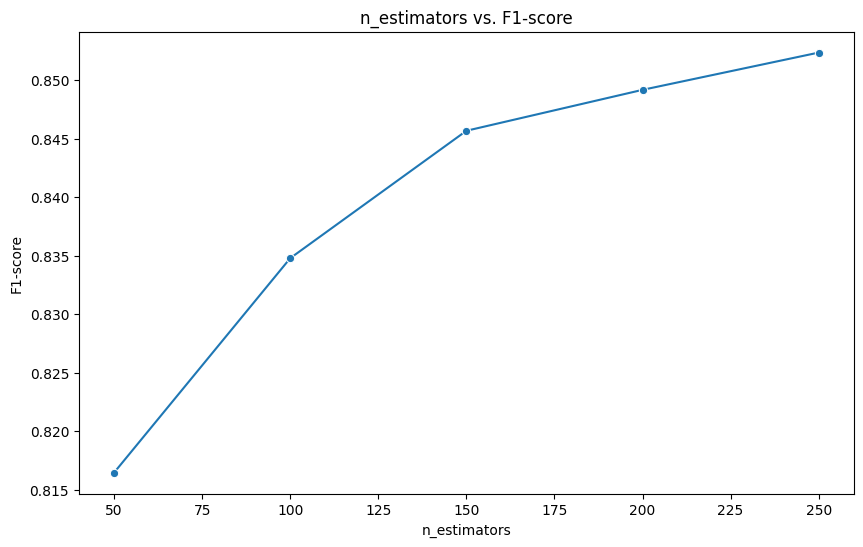

In [338]:
plt.figure(figsize=(10, 6))

# Plotting n_estimators vs. f1
sns.lineplot(x=list(range(50, 300, 50)), y=grid_search_n_estimators.cv_results_['mean_test_score'], marker='o')
plt.title('n_estimators vs. F1-score')
plt.xlabel('n_estimators')
plt.ylabel('F1-score')
plt.show()

More obvious improvement can been seen when n_estimators increases from 50 to 150, but after that the improvement is more subtle. Therefore, we will adopt n_estimators=150 for the following tuning.

#### Tune learning_rate

In [750]:
parameters_learning_rate = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
model = GradientBoostingClassifier(n_estimators=150, random_state=47)
grid_search_learning_rate = GridSearchCV(model, param_grid=parameters_learning_rate, cv=5, scoring='f1', verbose=1)
grid_search_learning_rate.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2]}, scoring='f1',
             verbose=1)

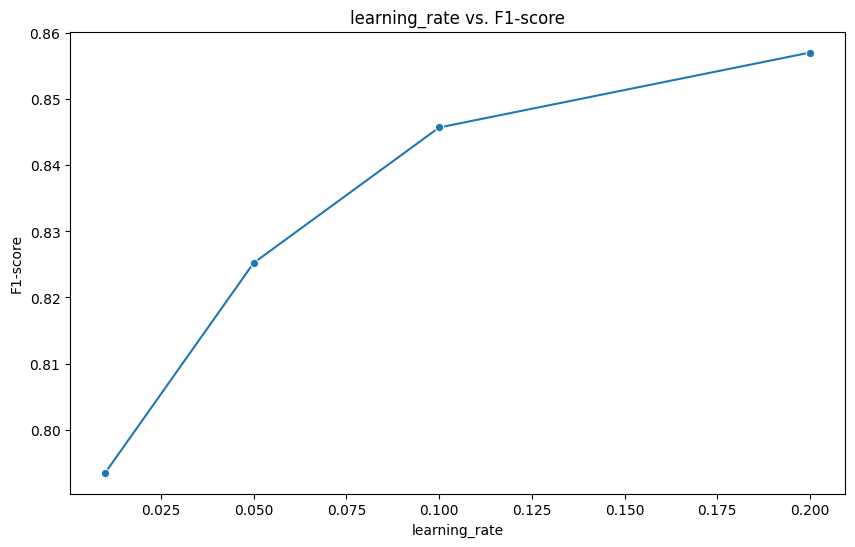

In [340]:
plt.figure(figsize=(10, 6))

# Plotting learning rate vs. f1
sns.lineplot(x=[0.01, 0.05, 0.1, 0.2], y=grid_search_learning_rate.cv_results_['mean_test_score'], marker='o')
plt.title('learning_rate vs. F1-score')
plt.xlabel('learning_rate')
plt.ylabel('F1-score')
plt.show()

learning_rate = 0.1 remains as the optimal solution, as after that the improvement is much slower.

#### Tune max_depth, min_samples_split, and min_samples_leaf

In [751]:
parameters_tree = {
    'max_depth':range(2,5,1), 
    'min_samples_split':[2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 5, 10]
    }
model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, random_state=47)
grid_search_tree = GridSearchCV(model, param_grid=parameters_tree, cv=5, scoring='f1', verbose=1)
grid_search_tree.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'max_depth': range(2, 5),
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=1)

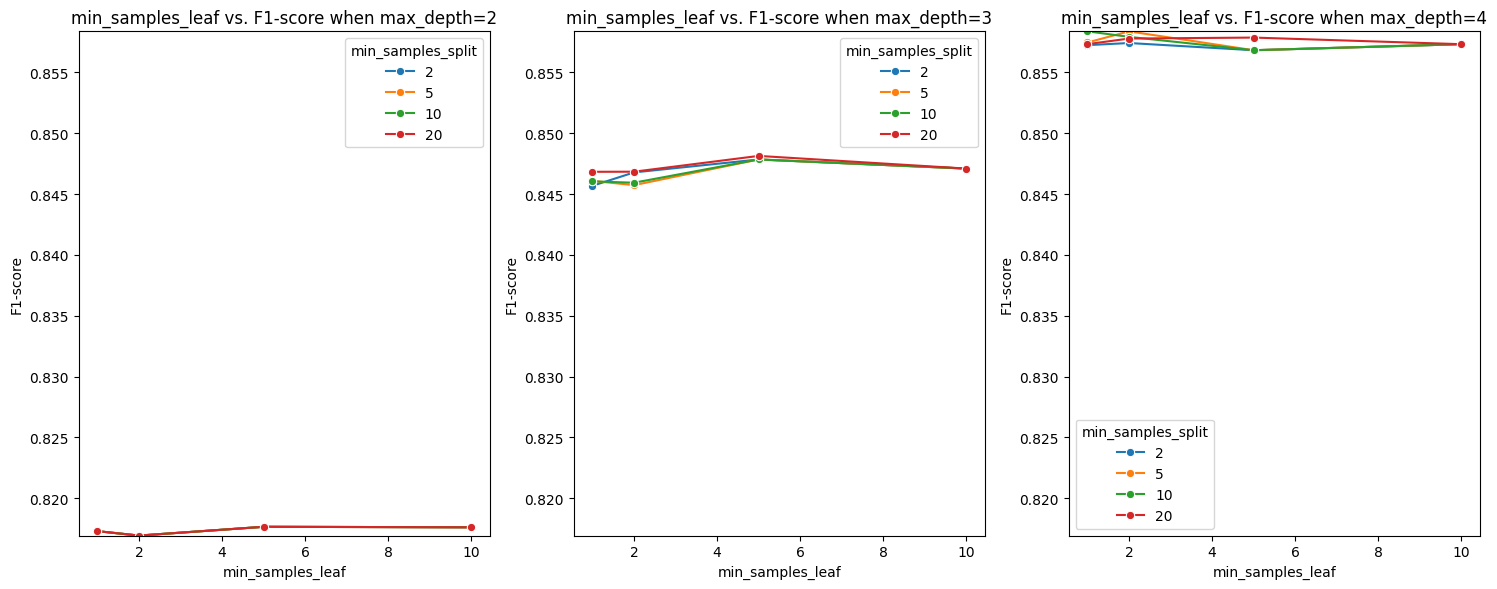

In [342]:
plt.figure(figsize=(15, 6))

# Plotting max_depth, min_samples_leaf, min_samples_split vs. f1
for i in range(3):
    plt.subplot(1, 3, i+1)
    for j in range(4):
        sns.lineplot(x=[1, 2, 5, 10], y=grid_search_tree.cv_results_['mean_test_score'][list(range(j+i*16, 16+i*16, 4))], marker='o', label=f'{[2, 5, 10, 20][j]}')
    plt.title(f'min_samples_leaf vs. F1-score when max_depth={[2,3,4][i]}')
    plt.ylim(min(grid_search_tree.cv_results_['mean_test_score']), max(grid_search_tree.cv_results_['mean_test_score']))
    plt.xlabel('min_samples_leaf')
    plt.ylabel('F1-score')
    plt.legend(title="min_samples_split") 
    plt.tight_layout()
plt.show()

The performance difference introcuded by min_samples_leaf and min_samples_split seems very subtle, so we will keep their default settings, i.e. min_samples_leaf=1 and min_samples_split=2. Subsequently, we want to tune max_depth alone to reveal clearer pattern.

#### Tune max_depth alone

In [752]:
parameters_max_depth = {
    'max_depth':range(2,8,1)
    }
model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, random_state=47)
grid_search_max_depth = GridSearchCV(model, param_grid=parameters_max_depth, cv=5, scoring='f1', verbose=1)
grid_search_max_depth.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'max_depth': range(2, 8)}, scoring='f1', verbose=1)

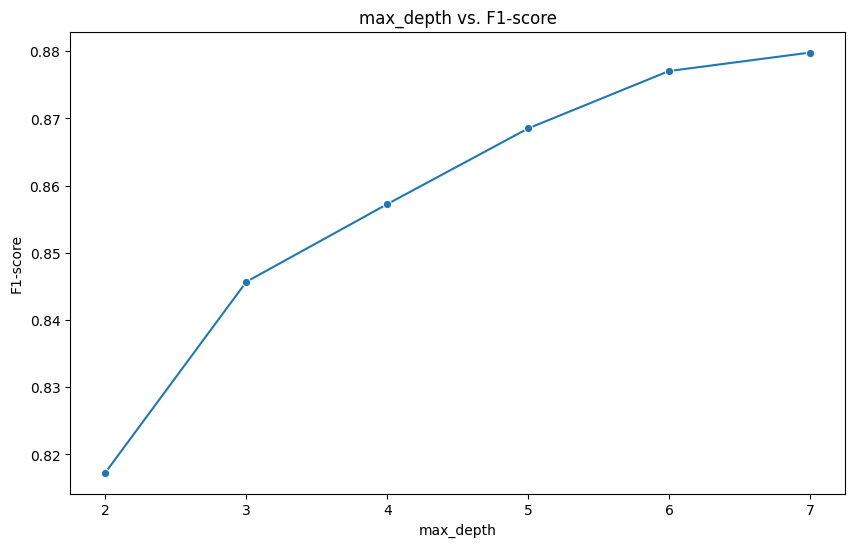

In [344]:
plt.figure(figsize=(10, 6))

# Plotting max_depth vs. f1
sns.lineplot(x=range(2,8,1), y=grid_search_max_depth.cv_results_['mean_test_score'], marker='o')
plt.title('max_depth vs. F1-score')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

The results show that model performance keeps improving as max_depth increases. However, this may be because the model overfit to the training data. To avoid such situations from happening, we opt for a smaller max_depth and keep the default setting: max_depth=6.

#### Tune subsample and max_features

In [753]:
parameters_subsample = {
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_features': [0.6, 0.8, 1]
    }
model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, max_depth=6, random_state=47)
grid_search_subsample = GridSearchCV(model, param_grid=parameters_subsample, cv=5, scoring='f1', verbose=1)
grid_search_subsample.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=6, n_estimators=30,
                                                  random_state=47),
             param_grid={'max_features': [0.6, 0.8, 1],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             scoring='f1', verbose=1)

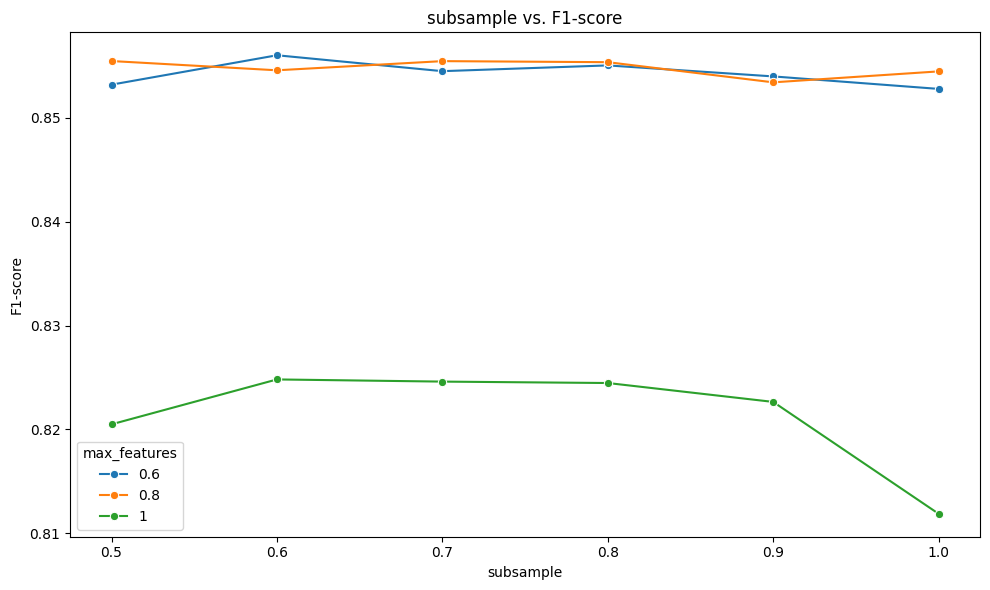

In [346]:
plt.figure(figsize=(10, 6))

# Plotting subsample, max_feature vs. f1
for i in range(3):
    sns.lineplot(x=[0.5, 0.6, 0.7, 0.8, 0.9, 1], y=grid_search_subsample.cv_results_['mean_test_score'][list(range(i*6, 6+i*6, 1))], marker='o', label=f"{['0.6', '0.8', '1'][i]}")
plt.title(f'subsample vs. F1-score')
plt.xlabel('subsample')
plt.ylabel('F1-score')
plt.legend(title="max_features") 
plt.tight_layout()
plt.show()

When max_feature=0.8 and subsample=0.6, it provides the optimal performance, so we will adopt that.

### Fit the Model again the tuned hyperparameters

In [347]:
gb_tuned = GradientBoostingClassifier(n_estimators=150, max_depth=6, max_features=0.8, subsample=0.6, random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [348]:
# Predict the output based on our training and testing dataset
Y_train_pred_tuned = gb_tuned.predict(X_train[final_columns])
Y_test_pred_tuned = gb_tuned.predict(X_test[final_columns])

In [349]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "Hyperparameter Tuned", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.910847391133778
Precision 	: 0.923216811477066
Recall 		: 0.896233817183209
F1 Score 	: 0.9095252314123617

**Test Set Metrics**
Accuracy 	: 0.8257093933463796
Precision 	: 0.5866486850977748
Recall 		: 0.5172413793103449
F1 Score 	: 0.5497630331753556


### Evaluation

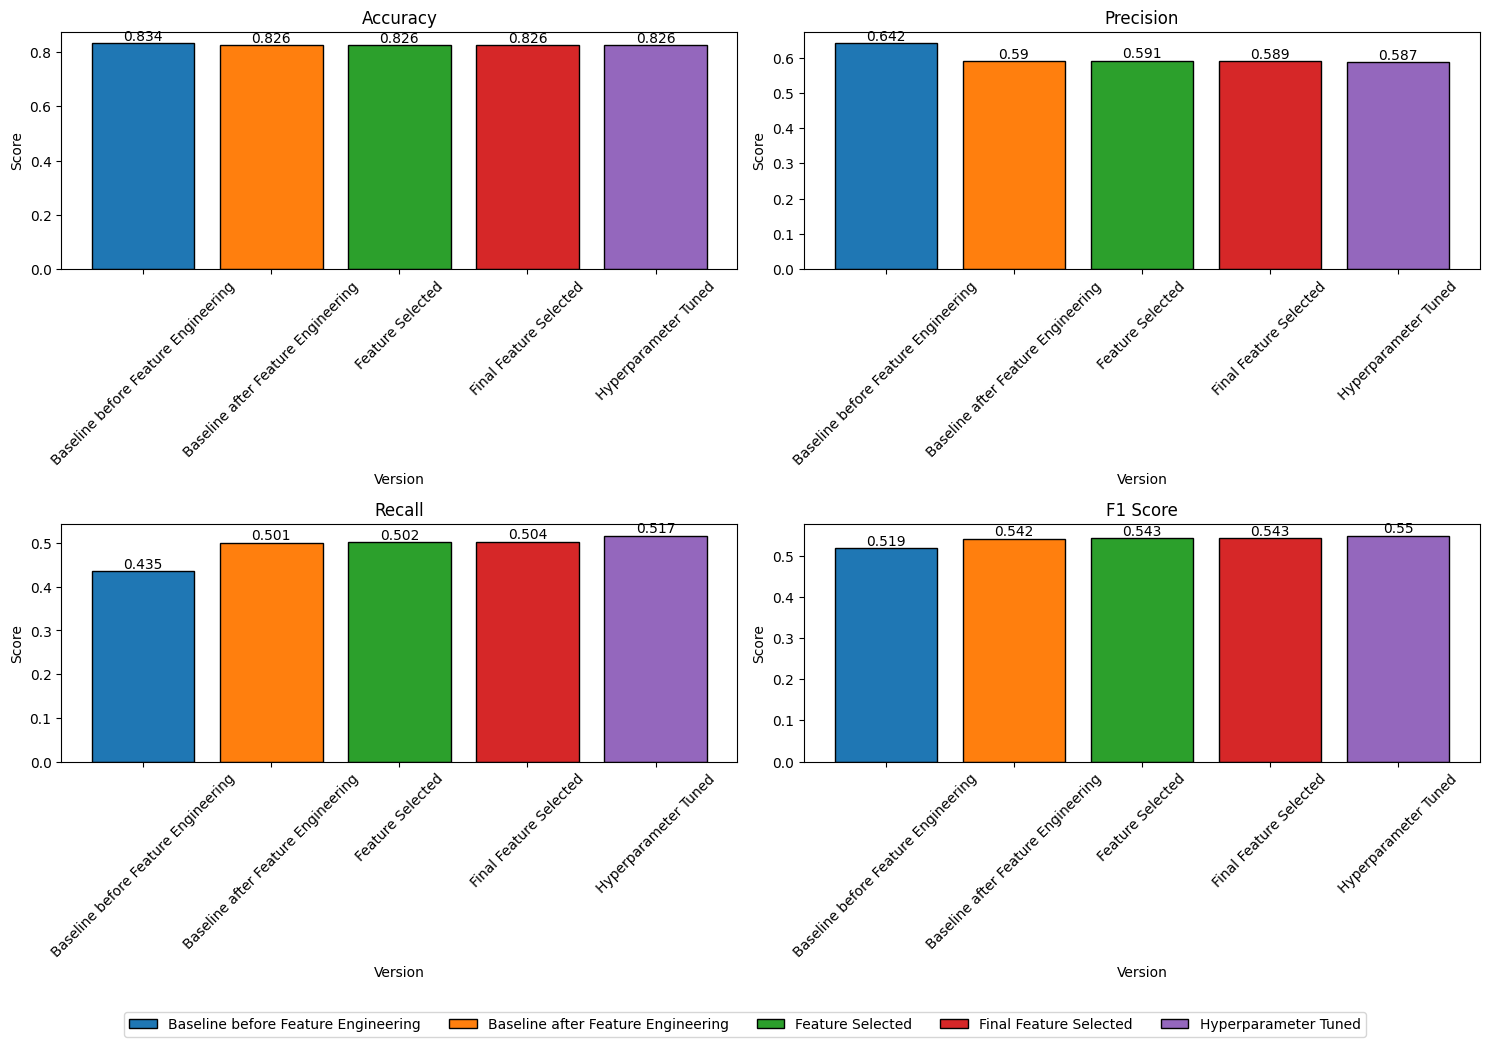

In [350]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

colormap = plt.cm.get_cmap('tab10')

for i, data in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    colors = colormap.colors[:len(test_metrics['Version'])]
    for index, (model, value) in enumerate(zip(test_metrics['Version'], test_metrics[data])):
        axs[i].bar(model, value, color=colors[index], label=model if i == 0 else "", edgecolor='k')
    axs[i].set_title(data)
    axs[i].set_ylabel('Score')
    axs[i].set_xlabel('Version')
    axs[i].set_xticks(test_metrics['Version'])
    axs[i].set_xticklabels(test_metrics['Version'], rotation=45)
    for index, value in enumerate(test_metrics[data]):
        axs[i].text(index, value, str(round(value, 3)), ha='center', va='bottom')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=len(test_metrics['Version']))

plt.tight_layout()
plt.show()

## LightGBM

In [705]:
from lightgbm import LGBMClassifier

In [706]:
# Set up a dataframe to store the results from different versions
train_metrics_lgbm = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics_lgbm = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

### Build the Baseline Model before Feature Engineering

In [707]:
lgbm_basic = LGBMClassifier(random_state=47).fit(X_train_basic, Y_train.values.ravel())

In [708]:
# Predict the output based on our training and testing dataset
Y_train_pred_basic = lgbm_basic.predict(X_train_basic)
Y_test_pred_basic = lgbm_basic.predict(X_test_basic)

In [744]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Baseline before Feature Engineering", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8985876814437034
Precision 	: 0.9121703853955375
Recall 		: 0.8821106316202433
F1 Score 	: 0.8968887116074991

**Test Set Metrics**
Accuracy 	: 0.8280332681017613
Precision 	: 0.6339805825242718
Recall 		: 0.3882282996432818
F1 Score 	: 0.48156342182890854


### Build the Baseline Model after Feature Engineering

In [710]:
lgbm = LGBMClassifier(random_state=47).fit(X_train, Y_train.values.ravel())

In [711]:
# Predict the output based on our training and testing dataset
Y_train_pred = lgbm.predict(X_train)
Y_test_pred = lgbm.predict(X_test)

In [745]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "Baseline after Feature Engineering", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8921635935661043
Precision 	: 0.9090537084398977
Recall 		: 0.8715182424480188
F1 Score 	: 0.8898903409944419

**Test Set Metrics**
Accuracy 	: 0.8226516634050881
Precision 	: 0.5780619111709286
Recall 		: 0.5107015457788348
F1 Score 	: 0.5422979797979798


#### Fit the Model again with the selected set of features

In [713]:
lgbm_selected = LGBMClassifier(random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

In [714]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected = lgbm_selected.predict(X_train[selected_columns])
Y_test_pred_selected = lgbm_selected.predict(X_test[selected_columns])

In [746]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8928010984699882
Precision 	: 0.9100962523039116
Recall 		: 0.87171439780306
F1 Score 	: 0.8904919346758843

**Test Set Metrics**
Accuracy 	: 0.8257093933463796
Precision 	: 0.5881949210706932
Recall 		: 0.509512485136742
F1 Score 	: 0.5460337687161516


### Eliminate Features with low in-built feature importance

In [716]:
# Get feature importance score
feature_importances = lgbm_selected.feature_importances_
# Get feature names
feature_names = selected_columns

# Remove features with feature_importances<=30
feature_names = feature_names[feature_importances>30]
feature_importances = feature_importances[feature_importances>30]

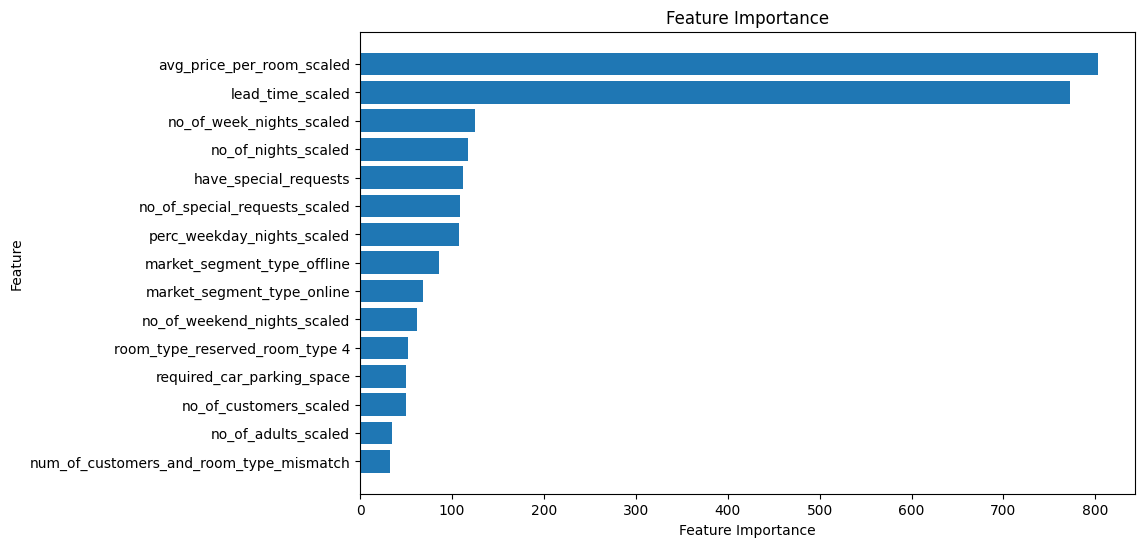

In [717]:
# Get indices that would sort feature importances
sorted_indices = np.argsort(feature_importances)
# Visualize permutation_importance
plot_feature_importance(feature_importances[sorted_indices], feature_names[sorted_indices])


Besides, there are some highly correlated columns, and we will remove one of them that contributes less to the model.

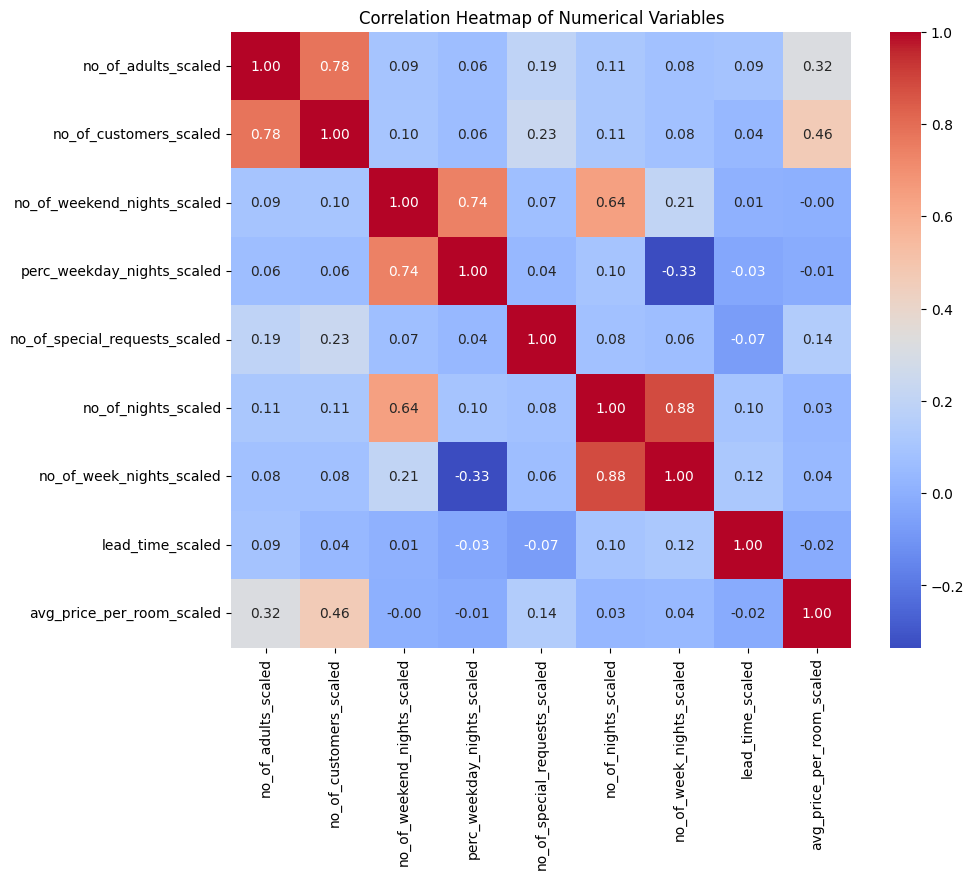

In [718]:
num_cols = [x for x in feature_names[sorted_indices] if '_scaled' in x]
plot_corrlation_heatmap(X_train[num_cols])

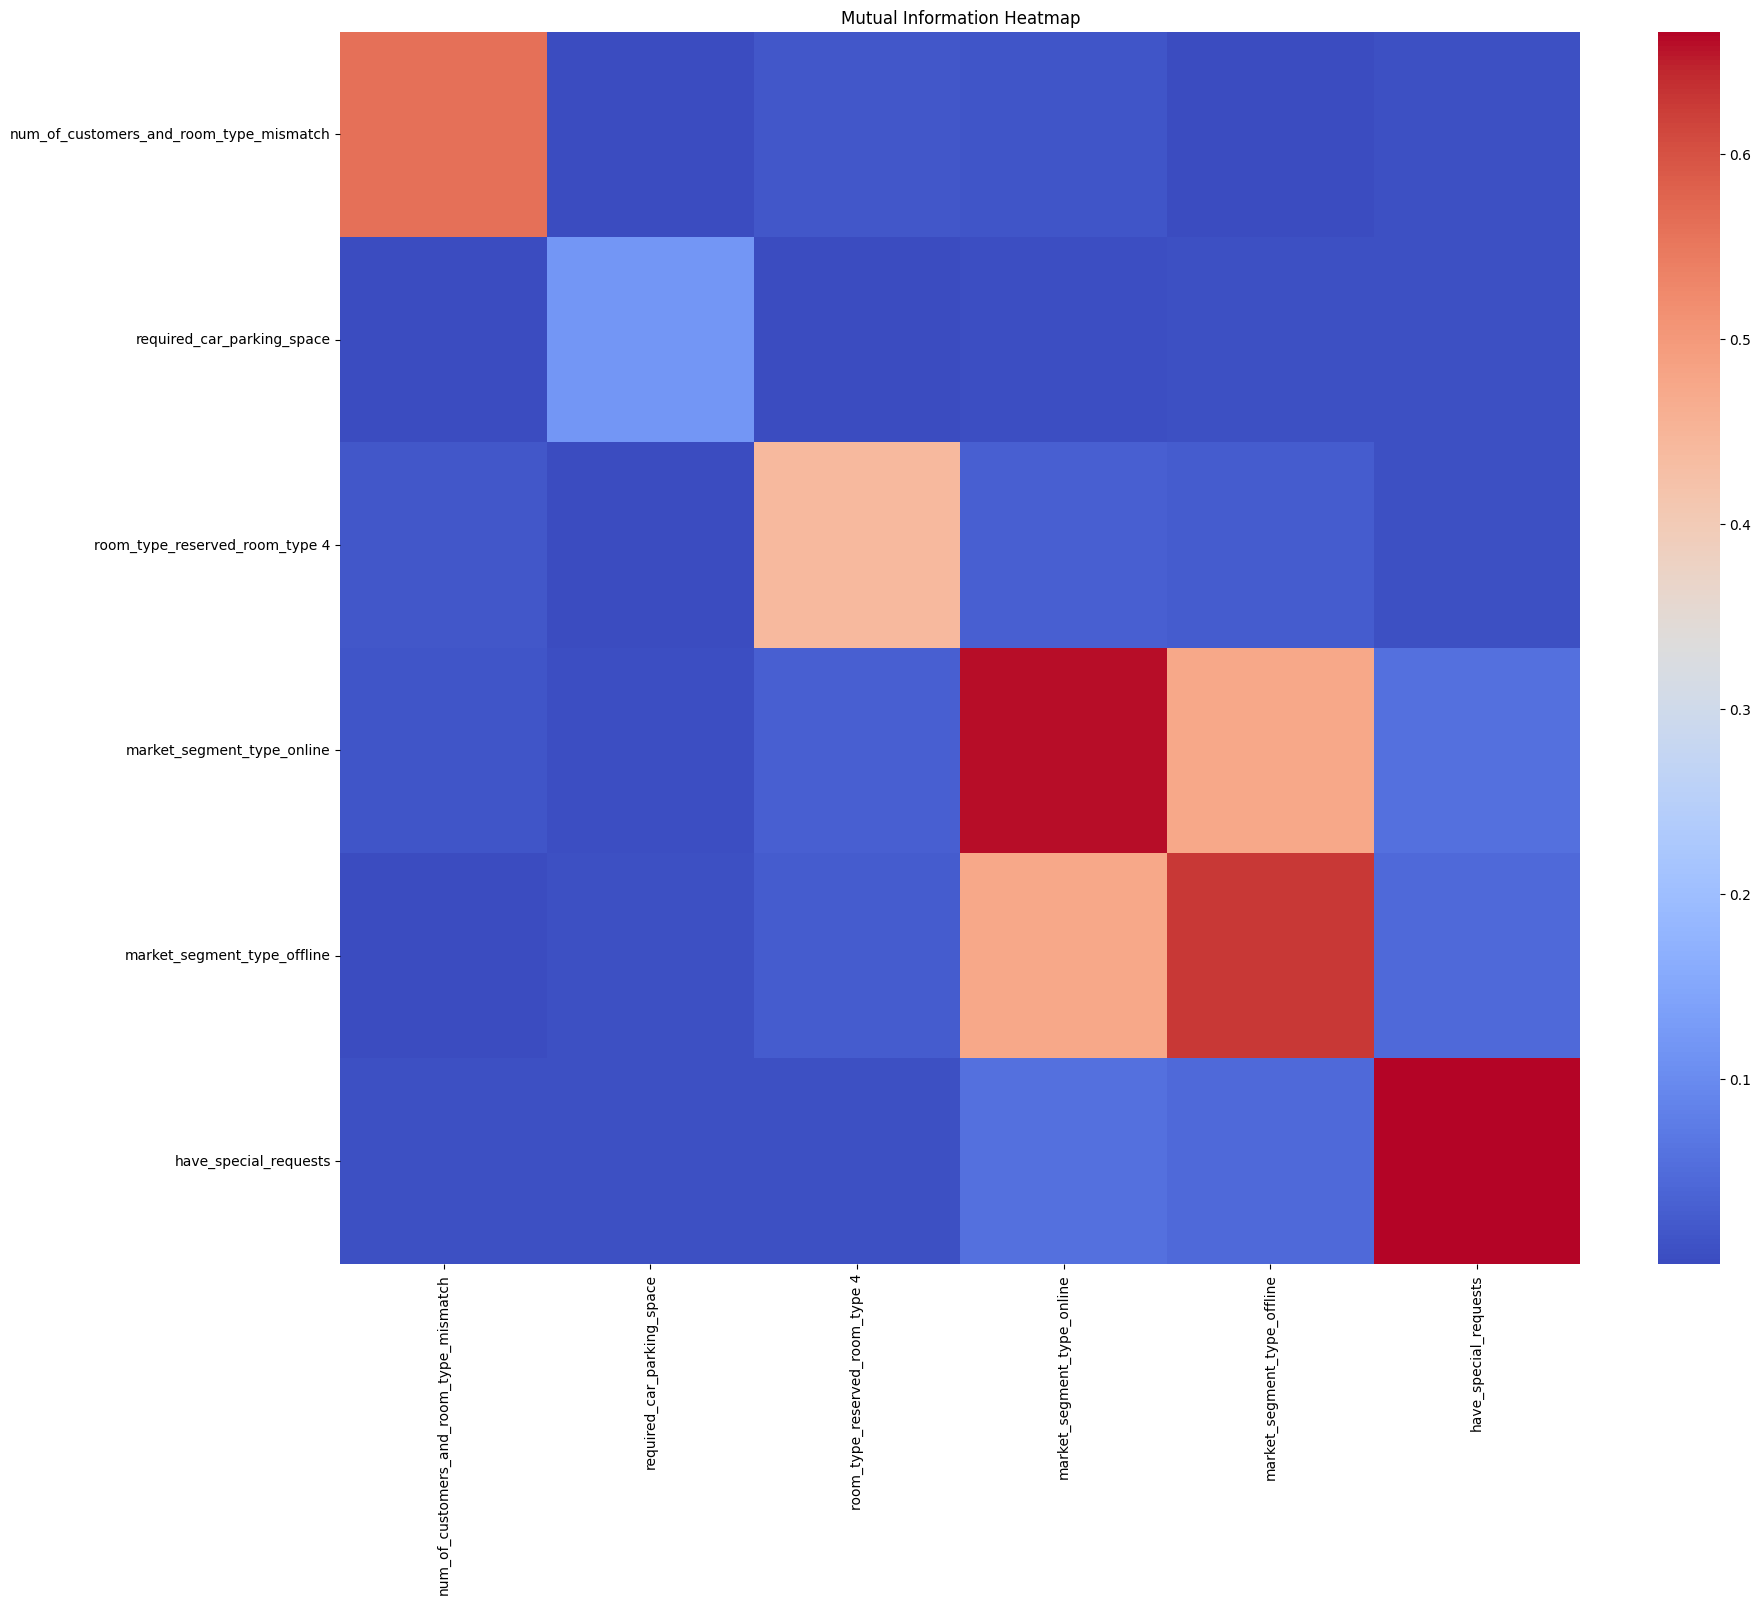

In [719]:
cat_cols = [x for x in feature_names[sorted_indices] if x not in num_cols]
plot_mi_heatmap(X_train[cat_cols])

Based on the observations, 'no_of_nights_scaled', 'no_of_week_nights_scaled', 'num_of_adults_scaled', 'market_segment_type_offline' will be removed.

In [720]:
to_remove = ['no_of_nights_scaled', 'no_of_week_nights_scaled', 'num_of_adults_scaled', 'market_segment_type_offline']
final_columns = [x for x in feature_names[sorted_indices] if x not in to_remove]

### Fit the model with the final set of features

In [721]:
lgbm_selected_final = LGBMClassifier(random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [722]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected_final = lgbm_selected_final.predict(X_train[final_columns])
Y_test_pred_selected_final = lgbm_selected_final.predict(X_test[final_columns])

In [723]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected_final, Y_test, Y_test_pred_selected_final, "Final Feature Selected", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.885347194978423
Precision 	: 0.9033052761239991
Recall 		: 0.8630835621812476
F1 Score 	: 0.8827364830976026

**Test Set Metrics**
Accuracy 	: 0.826320939334638
Precision 	: 0.5885135135135136
Recall 		: 0.5178359096313913
F1 Score 	: 0.5509171410499685


### Hyperparameter Tuning

For LightGBM, there are several hyperparameters to tune:
1. num_leaves (default=31): Maximum tree leaves for base learners controls the maximum number of leaves in each tree. Higher values can increase model complexity but may also lead to overfitting.
2. max_depth (default=-1): Maximum depth of tree. Deeper trees can capture more complex patterns in the data but may also lead to overfitting.
3. learning_rate (default=0.1): Learning rate determines the step size at each iteration while moving towards a minimum of the loss function. Lower values require more iterations but can lead to better convergence.
4. min_split_gain (default=0): Minimum loss reduction required to make a further partition on a leaf node of the tree. Increasing this value can help prevent overfitting.
5. colsample_bytree (default=1): Fraction of features (columns) used for training each tree. This can be used to introduce randomness and reduce overfitting.
6. reg_lambda (default=0): L2 regularization term on weights. This penalty term helps prevent overfitting by discouraging large weights.

#### Tune num_leaves

In [724]:
parameters_num_leaves = {
    'num_leaves': range(20, 80, 10),
    }
model = LGBMClassifier(random_state=47)
grid_search_num_leaves = GridSearchCV(model, param_grid=parameters_num_leaves, cv=5, scoring='f1', verbose=1)
grid_search_num_leaves.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=47),
             param_grid={'num_leaves': range(20, 80, 10)}, scoring='f1',
             verbose=1)

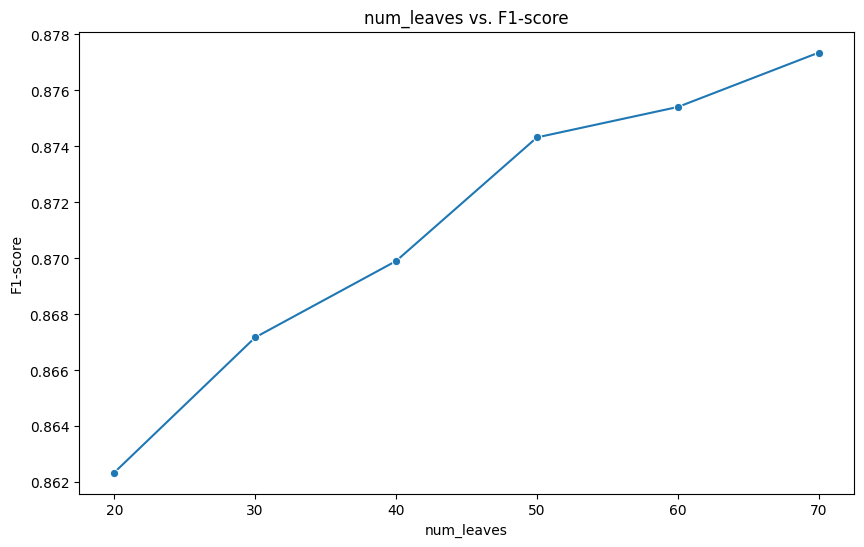

In [725]:
plt.figure(figsize=(10, 6))

# Plotting num_leaves vs. f1
sns.lineplot(x=list(range(20, 80, 10)), y=grid_search_num_leaves.cv_results_['mean_test_score'], marker='o')
plt.title('num_leaves vs. F1-score')
plt.xlabel('num_leaves')
plt.ylabel('F1-score')
plt.show()

While the model performance keeps increasing as the number of leaves increases, to prevent overfitting, we will adopt the num_leaves=45.

#### Tune max_depth

In [726]:
parameters_max_depth = {
    'max_depth': range(3, 10, 1),
    }
model = LGBMClassifier(num_leaves=45, random_state=47)
grid_search_max_depth = GridSearchCV(model, param_grid=parameters_max_depth, cv=5, scoring='f1', verbose=1)
grid_search_max_depth.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(num_leaves=45, random_state=47),
             param_grid={'max_depth': range(3, 10)}, scoring='f1', verbose=1)

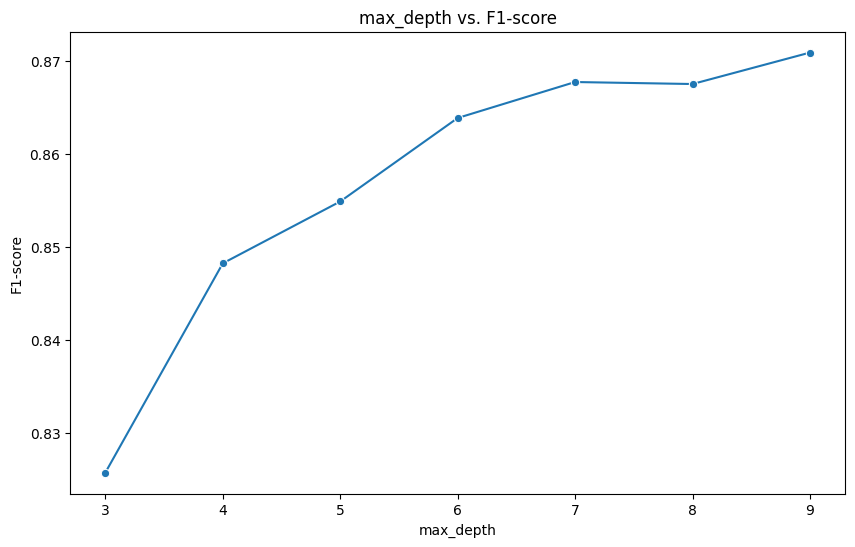

In [727]:
plt.figure(figsize=(10, 6))

# Plotting max_depth vs. f1
sns.lineplot(x=list(range(3, 10, 1)), y=grid_search_max_depth.cv_results_['mean_test_score'], marker='o')
plt.title('max_depth vs. F1-score')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

max_depth=6 provides the optimal performance, as after that the improvement is much subtle.

#### Tune learning_rate

In [728]:
parameters_learning_rate = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    }
model = LGBMClassifier(num_leaves=45, max_depth=6, random_state=47)
grid_search_learning_rate = GridSearchCV(model, param_grid=parameters_learning_rate, cv=5, scoring='f1', verbose=1)
grid_search_learning_rate.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, num_leaves=45,
                                      random_state=47),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5]},
             scoring='f1', verbose=1)

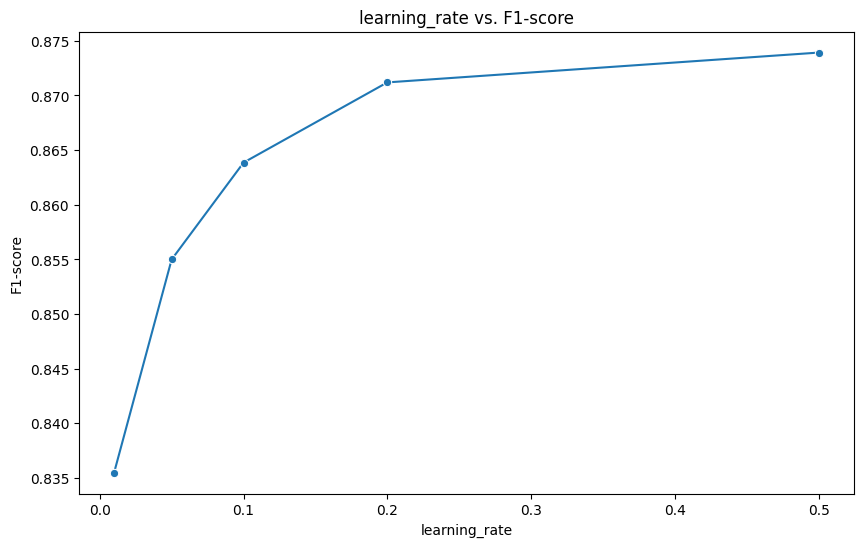

In [729]:
plt.figure(figsize=(10, 6))

# Plotting learning_rate vs. f1
sns.lineplot(x=[0.01, 0.05, 0.1, 0.2, 0.5], y=grid_search_learning_rate.cv_results_['mean_test_score'], marker='o')
plt.title('learning_rate vs. F1-score')
plt.xlabel('learning_rate')
plt.ylabel('F1-score')
plt.show()

The default value learning_rate=0.1 gives the optimal performance.

#### Tune min_split_gain

In [730]:
parameters_min_split_gain = {
    'min_split_gain': [0, 0.1, 0.2, 0.5, 1]
    }
model = LGBMClassifier(num_leaves=45, max_depth=6, learning_rate=0.1, random_state=47)
grid_search_min_split_gain = GridSearchCV(model, param_grid=parameters_min_split_gain, cv=5, scoring='f1', verbose=1)
grid_search_min_split_gain.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, num_leaves=45,
                                      random_state=47),
             param_grid={'min_split_gain': [0, 0.1, 0.2, 0.5, 1]}, scoring='f1',
             verbose=1)

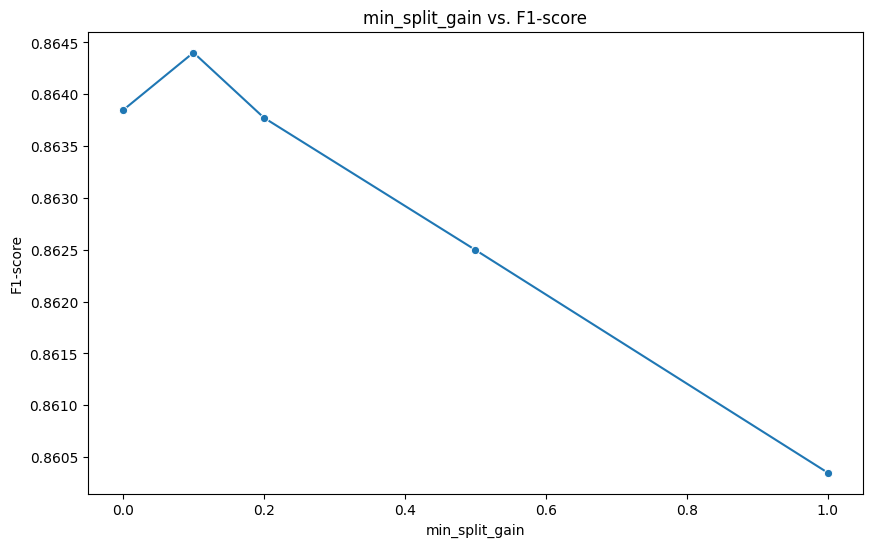

In [731]:
plt.figure(figsize=(10, 6))

# Plotting min_split_gain vs. f1
sns.lineplot(x=[0, 0.1, 0.2, 0.5, 1], y=grid_search_min_split_gain.cv_results_['mean_test_score'], marker='o')
plt.title('min_split_gain vs. F1-score')
plt.xlabel('min_split_gain')
plt.ylabel('F1-score')
plt.show()

min_split_gain=0.1 provides the best performance.

#### Tune colsample_bytree

In [732]:
parameters_colsample = {
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
model = LGBMClassifier(num_leaves=45, max_depth=6, learning_rate=0.1, min_split_gain=0.1, random_state=47)
grid_search_colsample = GridSearchCV(model, param_grid=parameters_colsample, cv=5, scoring='f1', verbose=1)
grid_search_colsample.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, min_split_gain=0.1,
                                      num_leaves=45, random_state=47),
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             scoring='f1', verbose=1)

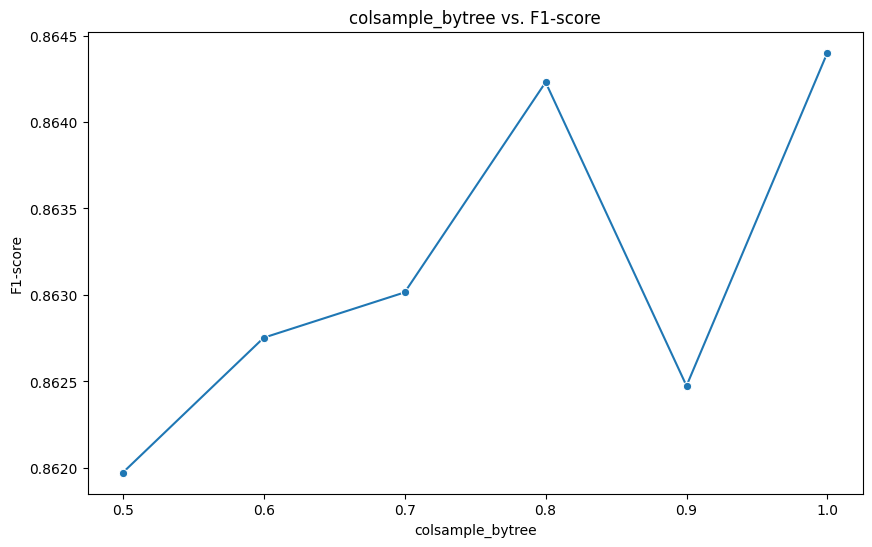

In [733]:
plt.figure(figsize=(10, 6))

# Plotting colsample_bytree vs. f1
sns.lineplot(x=[0.5, 0.6, 0.7, 0.8, 0.9, 1], y=grid_search_colsample.cv_results_['mean_test_score'], marker='o')
plt.title('colsample_bytree vs. F1-score')
plt.xlabel('colsample_bytree')
plt.ylabel('F1-score')
plt.show()

Performance variation introduced by colsample_bytree is not significant, so we will keep the default value colsample_bytree=1.

#### Tune reg_lambda

In [734]:
parameters_reg = {
    'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5, 3]
    }
model = LGBMClassifier(num_leaves=45, max_depth=6, learning_rate=0.1, min_split_gain=0.1, random_state=47)
grid_search_reg = GridSearchCV(model, param_grid=parameters_reg, cv=5, scoring='f1', verbose=1)
grid_search_reg.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, min_split_gain=0.1,
                                      num_leaves=45, random_state=47),
             param_grid={'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5, 3]},
             scoring='f1', verbose=1)

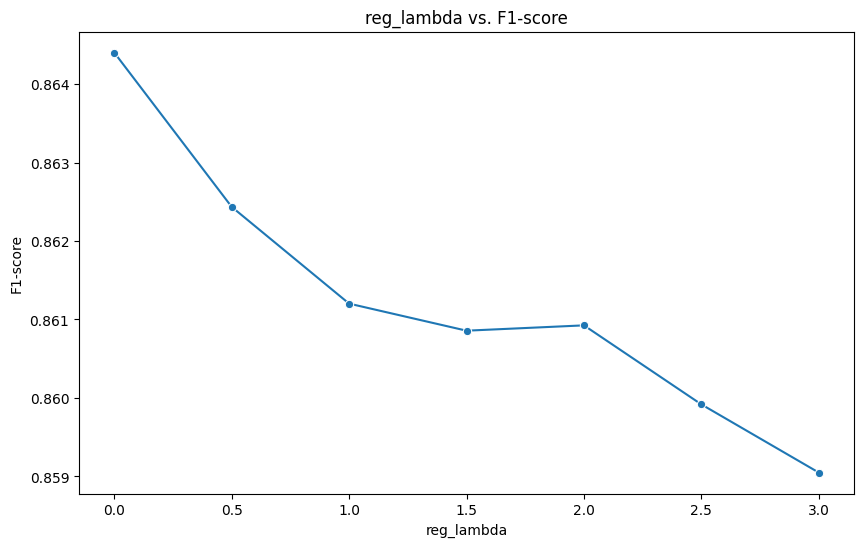

In [735]:
plt.figure(figsize=(10, 6))

# Plotting reg_lambda vs. f1
sns.lineplot(x=[0, 0.5, 1, 1.5, 2, 2.5, 3], y=grid_search_reg.cv_results_['mean_test_score'], marker='o')
plt.title('reg_lambda vs. F1-score')
plt.xlabel('reg_lambda')
plt.ylabel('F1-score')
plt.show()

While introducing regularization will reduce the f1 score for training set, to reduce overfitting, we will set reg_lambda=2.

### Fit the Model again the tuned hyperparameters

In [736]:
lgbm_tuned = LGBMClassifier(num_leaves=45, max_depth=6, learning_rate=0.1, min_split_gain=0.1, reg_lambda=2).fit(X_train[final_columns], Y_train.values.ravel())

In [737]:
# Predict the output based on our training and testing dataset
Y_train_pred_tuned = lgbm_tuned.predict(X_train[final_columns])
Y_test_pred_tuned = lgbm_tuned.predict(X_test[final_columns])

In [747]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "Hyperparameter Tuned", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8753432718713221
Precision 	: 0.8942109600329625
Recall 		: 0.8514123185562966
F1 Score 	: 0.8722869774919615

**Test Set Metrics**
Accuracy 	: 0.8296232876712328
Precision 	: 0.6
Recall 		: 0.5154577883472057
F1 Score 	: 0.5545251039334825


### Evaluation

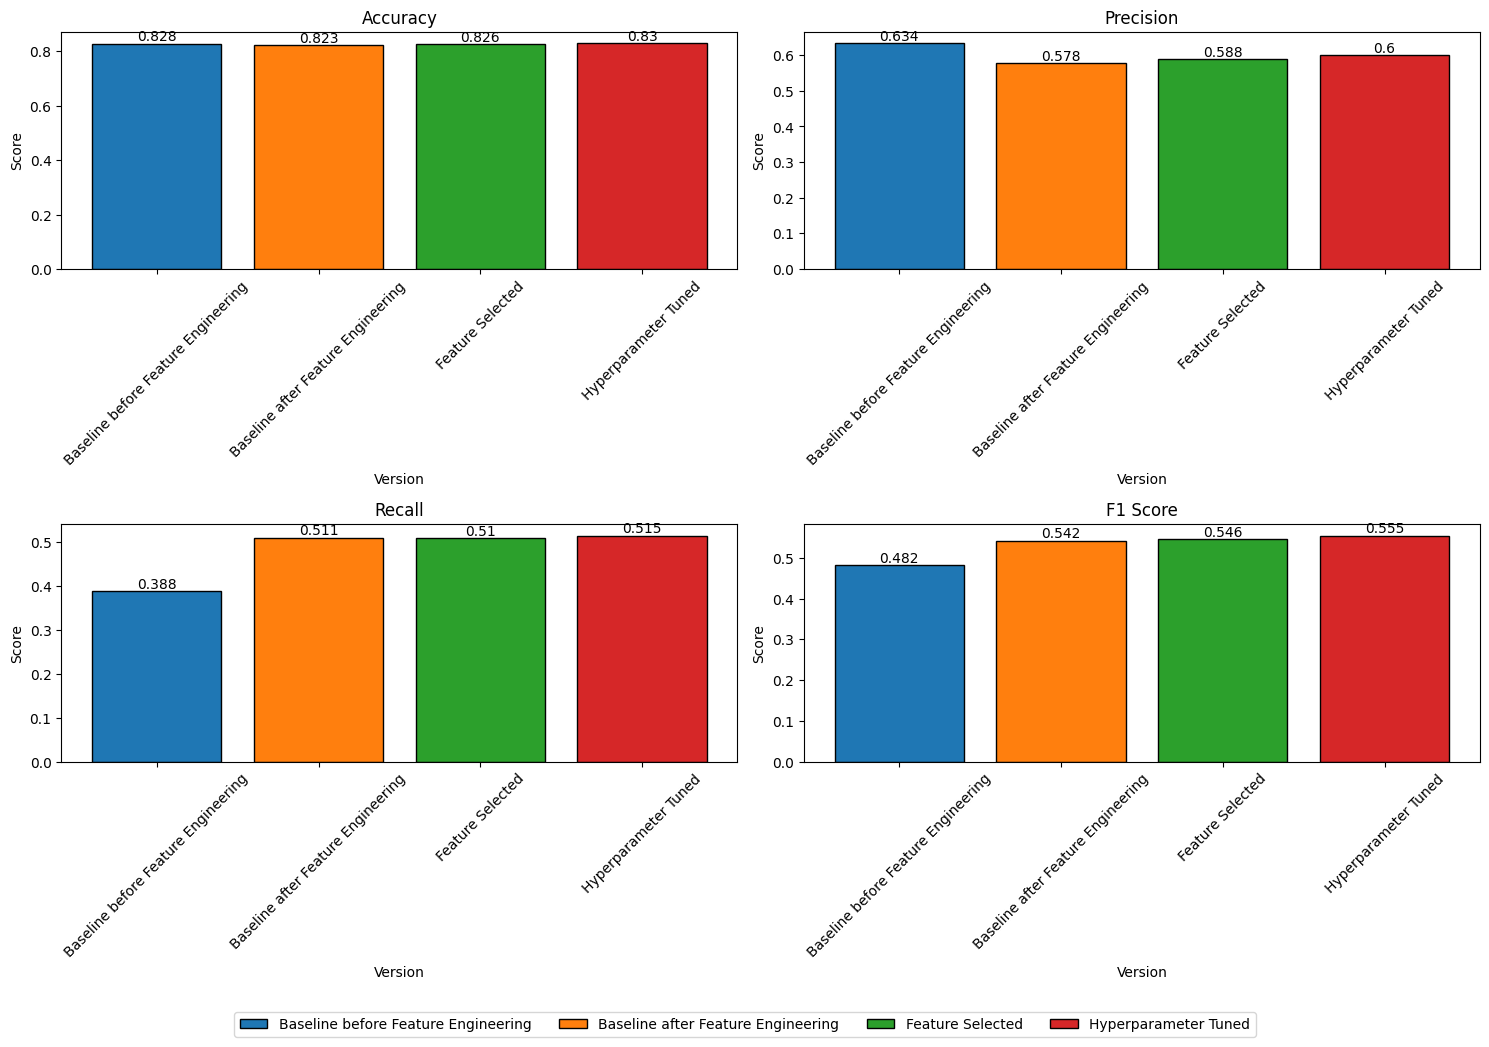

In [748]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

colormap = plt.cm.get_cmap('tab10')

for i, data in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    colors = colormap.colors[:len(test_metrics_lgbm['Version'])]
    for index, (model, value) in enumerate(zip(test_metrics_lgbm['Version'], test_metrics_lgbm[data])):
        axs[i].bar(model, value, color=colors[index], label=model if i == 0 else "", edgecolor='k')
    axs[i].set_title(data)
    axs[i].set_ylabel('Score')
    axs[i].set_xlabel('Version')
    axs[i].set_xticks(test_metrics_lgbm['Version'])
    axs[i].set_xticklabels(test_metrics_lgbm['Version'], rotation=45)
    for index, value in enumerate(test_metrics_lgbm[data]):
        axs[i].text(index, value, str(round(value, 3)), ha='center', va='bottom')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=len(test_metrics_lgbm['Version']))

plt.tight_layout()
plt.show()

### Alternative Method: Bayesian Optimization

Bayesian Optimization is a probabilistic model-based optimization technique used to find the maximum or minimum of an objective function over a bounded domain. It is particularly useful when the objective function is expensive to evaluate and noisy, as it aims to find the optimum with as few evaluations as possible. By iteratively updating the surrogate model and selecting the next sampling point based on the acquisition function, Bayesian Optimization efficiently explores the parameter space and converges to the optimal solution with a minimal number of evaluations of the objective function.

In [ ]:
from bayes_opt import BayesianOptimization
import lightgbm

In [579]:
data = lightgbm.Dataset(X_train[final_columns], label=Y_train.values.ravel())

# Define the objective function
def objective_function(num_leaves, max_depth, learning_rate, min_split_gain, subsample, colsample_bytree):
    params = {'application':'binary', 'metric':'auc', 'verbose':-1}
    params['num_leaves'] = int(num_leaves)
    params["max_depth"] = int(max_depth)
    params['learning_rate'] = round(learning_rate, 2)
    params['min_split_gain'] = round(min_split_gain, 2)
    params['subsample'] = round(subsample, 2)
    params['colsample_bytree'] = round(colsample_bytree, 2)
    
    cv_result = lightgbm.cv(params, data, nfold=5, seed=47, stratified=True, metrics=['auc'])
    return max(cv_result['auc-mean'])

# Specify the search space
search_space = {
    'num_leaves': (20, 50),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 1),
    'min_split_gain': (0.1, 1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# Initialize the BayesianOptimization object
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=search_space,
    random_state=47  # Optional: set random seed for reproducibility
)

# Run the optimization
optimizer.maximize(
    init_points=10,  # Number of random exploration points
    n_iter=100,      # Number of optimization iterations
)

# Retrieve the best hyperparameters
best_hyperparams = optimizer.max['params']

|   iter    |  target   | colsam... | learni... | max_depth | min_sp... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9341    | 0.5567    | 0.9747    | 8.101     | 0.4163    | 41.23     | 0.8998    |
| 2         | 0.9418    | 0.8228    | 0.4205    | 7.942     | 0.322     | 27.68     | 0.512     |
| 3         | 0.9386    | 0.5494    | 0.3074    | 7.486     | 0.39      | 25.56     | 0.9586    |
| 4         | 0.9436    | 0.6355    | 0.2808    | 9.681     | 0.2144    | 42.42     | 0.5026    |
| 5         | 0.9361    | 0.9284    | 0.699     | 6.871     | 0.9417    | 35.38     | 0.5888    |
| 6         | 0.9236    | 0.7684    | 0.3005    | 3.074     | 0.8954    | 39.69     | 0.9711    |
| 7         | 0.9365    | 0.8725    | 0.2745    | 5.533     | 0.5738    | 36.41     | 0.6293    |
| 8         | 0.9252    | 0.5873    | 0.3671    | 3.981     | 0.4502    | 34.16     | 0.9844    |
| 9         | 0.937 

In [580]:
best_hyperparams

{'colsample_bytree': 1.0,
 'learning_rate': 0.2509404266555085,
 'max_depth': 10.0,
 'min_split_gain': 0.1,
 'num_leaves': 40.87047583742487,
 'subsample': 0.5}